In [146]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier


In [169]:
df = pd.read_csv("../datasets/creditcard_2023.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568630 entries, 0 to 568629
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      568630 non-null  int64  
 1   V1      568630 non-null  float64
 2   V2      568630 non-null  float64
 3   V3      568630 non-null  float64
 4   V4      568630 non-null  float64
 5   V5      568630 non-null  float64
 6   V6      568630 non-null  float64
 7   V7      568630 non-null  float64
 8   V8      568630 non-null  float64
 9   V9      568630 non-null  float64
 10  V10     568630 non-null  float64
 11  V11     568630 non-null  float64
 12  V12     568630 non-null  float64
 13  V13     568630 non-null  float64
 14  V14     568630 non-null  float64
 15  V15     568630 non-null  float64
 16  V16     568630 non-null  float64
 17  V17     568630 non-null  float64
 18  V18     568630 non-null  float64
 19  V19     568630 non-null  float64
 20  V20     568630 non-null  float64
 21  V21     56

In [170]:
# df = df.sample(n=10000, random_state=42)
print(df)

            id        V1        V2        V3        V4        V5        V6  \
0            0 -0.260648 -0.469648  2.496266 -0.083724  0.129681  0.732898   
1            1  0.985100 -0.356045  0.558056 -0.429654  0.277140  0.428605   
2            2 -0.260272 -0.949385  1.728538 -0.457986  0.074062  1.419481   
3            3 -0.152152 -0.508959  1.746840 -1.090178  0.249486  1.143312   
4            4 -0.206820 -0.165280  1.527053 -0.448293  0.106125  0.530549   
...        ...       ...       ...       ...       ...       ...       ...   
568625  568625 -0.833437  0.061886 -0.899794  0.904227 -1.002401  0.481454   
568626  568626 -0.670459 -0.202896 -0.068129 -0.267328 -0.133660  0.237148   
568627  568627 -0.311997 -0.004095  0.137526 -0.035893 -0.042291  0.121098   
568628  568628  0.636871 -0.516970 -0.300889 -0.144480  0.131042 -0.294148   
568629  568629 -0.795144  0.433236 -0.649140  0.374732 -0.244976 -0.603493   

              V7        V8        V9  ...       V21       V22  

In [171]:
data = df.values
X = data[: , :-1]
y = data[: , -1]

In [172]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [173]:
import numpy as np

class DecisionStump:
    def __init__(self):
        self.threshold = None
        self.feature_index = None
        self.alpha = None
        self.prediction = None

    def fit(self, X, y, sample_weight):
        m, n = X.shape
        min_error = float('inf')

        for feature_index in range(n):
            # Сортировка признаков
            thresholds, unique_classes = zip(*sorted(zip(X[:, feature_index], y)))

            # Инициализация сумм весов классов
            total_positive_weight = sum(sample_weight * (y == 1))
            total_negative_weight = sum(sample_weight * (y == -1))
            current_negative_weight = 0

            for i in range(m):
                # Обновление веса отрицательного класса
                current_negative_weight += sample_weight[i] * (y[i] == -1)

                # Вычисление ошибки для текущего порога
                error = min(current_negative_weight + total_positive_weight - current_negative_weight,
                            current_negative_weight + total_negative_weight - current_negative_weight)

                # Обновление порога, если ошибка уменьшилась
                if error < min_error:
                    min_error = error
                    self.threshold = thresholds[i]
                    self.feature_index = feature_index

        # Вычисление веса для модели
        if min_error == 0 or min_error == 1:
            self.alpha = 0
        else:
            self.alpha = 0.5 * np.log((1 - min_error) / min_error)

        # Вычисление предсказания для модели
        self.prediction = np.ones(m)
        self.prediction[X[:, self.feature_index] < self.threshold] = -1

    def predict(self, X):
        # Бинарная классификация
        return np.where(X[:, self.feature_index] < self.threshold, -1, 1)

In [174]:
class AdaBoost:
    def __init__(self, n_estimators):
        self.n_estimators = n_estimators
        self.alphas = []  # Веса базовых моделей
        self.models = []  # Базовые модели

    def fit(self, X, y):
        m = X.shape[0]
        w = np.ones(m) / m  # Инициализация весов

        for _ in range(self.n_estimators):
            model = DecisionTreeClassifier(max_depth=1)  # Используем DecisionTreeClassifier вместо DecisionStump
            model.fit(X, y, sample_weight=w)  # Обучение базовой модели

            predictions = model.predict(X)
            error = np.sum(w * (predictions != y)) / np.sum(w)  # Вычисление ошибки

            alpha = 0.5 * np.log((1 - error) / error)  # Вычисление веса базовой модели
            w = w * np.exp(-alpha * y * predictions)  # Обновление весов

            self.alphas.append(alpha)
            self.models.append(model)

    def predict(self, X):
        # Суммируем предсказания базовых моделей, взвешенные их весами
        predictions = np.sum(alpha * model.predict(X) for alpha, model in zip(self.alphas, self.models))
        return np.sign(predictions)  # Возвращаем знак суммы

In [178]:
# Импорт и обучение модели AdaBoost
adaboost_model = AdaBoost(n_estimators=10)
adaboost_model.fit(X_train, y_train)

In [179]:
# Предсказание на тестовом наборе
y_pred = adaboost_model.predict(X_test)

C:\Users\Redmi\AppData\Local\Temp\ipykernel_23012\4211530775.py:26: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  predictions = np.sum(alpha * model.predict(X) for alpha, model in zip(self.alphas, self.models))


In [180]:
# Оценка точности модели
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9994812092221655


In [181]:
print(df)

            id        V1        V2        V3        V4        V5        V6  \
0            0 -0.260648 -0.469648  2.496266 -0.083724  0.129681  0.732898   
1            1  0.985100 -0.356045  0.558056 -0.429654  0.277140  0.428605   
2            2 -0.260272 -0.949385  1.728538 -0.457986  0.074062  1.419481   
3            3 -0.152152 -0.508959  1.746840 -1.090178  0.249486  1.143312   
4            4 -0.206820 -0.165280  1.527053 -0.448293  0.106125  0.530549   
...        ...       ...       ...       ...       ...       ...       ...   
568625  568625 -0.833437  0.061886 -0.899794  0.904227 -1.002401  0.481454   
568626  568626 -0.670459 -0.202896 -0.068129 -0.267328 -0.133660  0.237148   
568627  568627 -0.311997 -0.004095  0.137526 -0.035893 -0.042291  0.121098   
568628  568628  0.636871 -0.516970 -0.300889 -0.144480  0.131042 -0.294148   
568629  568629 -0.795144  0.433236 -0.649140  0.374732 -0.244976 -0.603493   

              V7        V8        V9  ...       V21       V22  

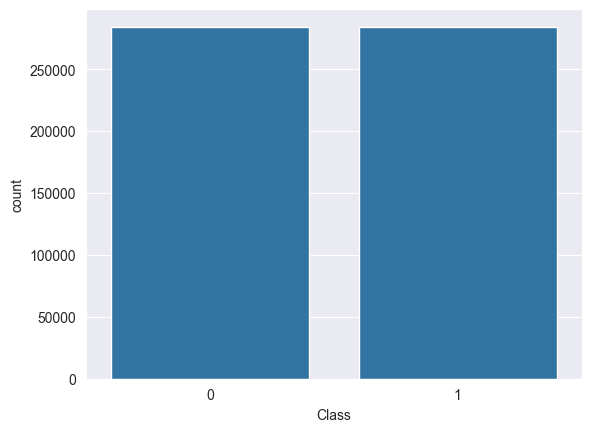

In [182]:
import seaborn as sns
import matplotlib.pyplot as plt

# График распределения классов
sns.countplot(x='Class', data=df)
plt.show()